# Time Series Forecasting con TF

Remasterizado de [esto](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/10_time_series_forecasting_in_tensorflow.ipynb)

Para este notebook voy a trabajar con la serie temporal de los precios de Bitcoin desde el 01 de octubre de 2013 hasta el 18 de mayo de 2018, pero vale cualquier serie de tiempo. Evidentemente.

In [1]:
# DESCARGA DE LOS DATOS MEDIANTE WGET
import wget
url = r'https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv'
# wget.download(url)
# Lo comento porque si no cada vez que ejecuto el notebook me descarga un csv nuevo

In [2]:
import pandas as pd
df = pd.read_csv("./BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"])
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


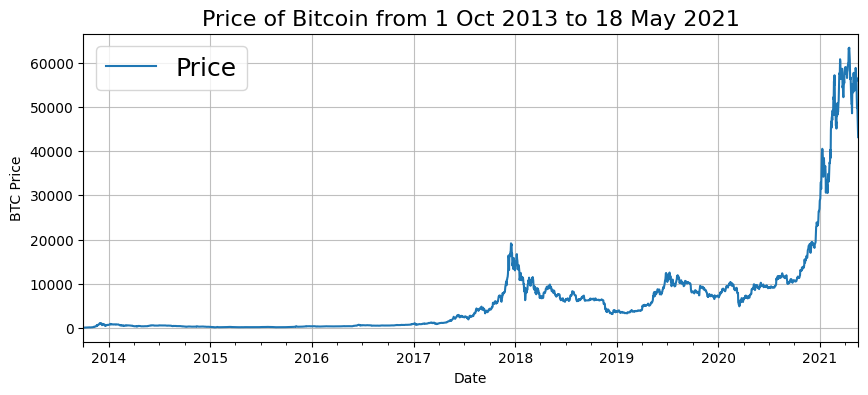

In [3]:
# Solo nos interesa el precio de cierre
bitcoinPrices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})

import matplotlib.pyplot as plt
bitcoinPrices.plot(figsize=(10, 4))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=18)
plt.grid(alpha = 0.8)

## Funciones auxiliares
Funciones auxiliares para plotear, formatear datos y demas menesteres que hagan falta. 

###  train_test_split_TS function 
Para hacer la partición entre datos de entrenamiento y datos de testeo, no podemos recurrir a la manera tradicional de hacerlo con sklearn por el siguiente motivo.

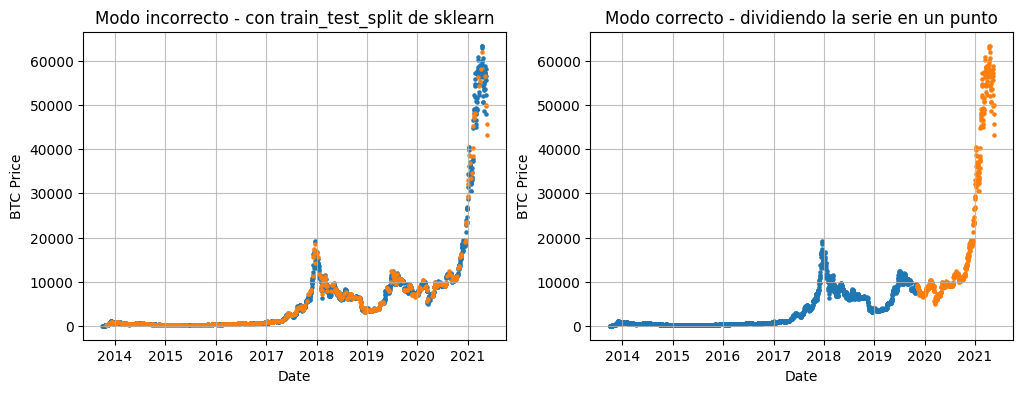

In [4]:
from sklearn.model_selection import train_test_split 

fig, ax = plt.subplots(1, 2, figsize = (12,4))

## MANERA TRADICIONAL, CON train_test_split
# hay que pasarlos a numpy
timesteps = bitcoinPrices.index.to_numpy()
prices = bitcoinPrices["Price"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(timesteps, # dates
                                                    prices, # prices
                                                    test_size=0.2,
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

ax[0].scatter(X_train, y_train, s=5, label="Train data")
ax[0].scatter(X_test, y_test, s=5, label="Test data")
ax[0].set_xlabel("Date")
ax[0].set_ylabel("BTC Price")
ax[0].set_title('Modo incorrecto - con train_test_split de sklearn')
ax[0].grid(alpha = 0.8)

## MODO CORRECTO, el train es el pasado, el test el futuro
splitSize = int(0.8 * len(prices)) # 80% train, 20% test

# TRAIN: toda la serie HASTA el punto de corte
X_train, y_train = timesteps[:splitSize], prices[:splitSize]
# TEST: toda la serie desde el DESDE de corte
X_test, y_test = timesteps[splitSize:], prices[splitSize:]

ax[1].scatter(X_train, y_train, s=5, label="Train data")
ax[1].scatter(X_test, y_test, s=5, label="Test data")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("BTC Price")
ax[1].set_title('Modo correcto - dividiendo la serie en un punto')
ax[1].grid(alpha = 0.8)

Con `train_test_split` de `sklearn` el resultado de la partición coge puntos a lo largo de toda la serie temporal tanto para el conjunto de entranamiento como para el de testeo, y no queremos eso. **Lo que queremos es predecir el futuro, respecto del pasado.**

````{admonition} train_test_split_TS 
:class: dropdown

``` python
def train_test_split_TS(windows, labels, test_split=0.2):
  """
  Divide parejas de ventanas y labels en conjuntos de entranamiento y testeo
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels
```

````

In [5]:
def train_test_split_TS(windows, labels, test_split=0.2):
  """
  Divide parejas de ventanas y labels en conjuntos de entranamiento y testeo
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

### plotTimeSeries function 
Igual nos facilita el trabajo. Let's see.


````{admonition} plotTimeSeries 
:class: dropdown
```python
def plotTimeSeries(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plotea una serie temporal (una serie de puntos en el tiempo) respecto a sus valores a lo largo del tiempo.

  Parameters
  ---------
      timesteps : array de puntos de tiempo
      values : array de valores
      format : estilo de la línea, default "."
      start : comienzo del gráfico (setting a value will index from start of timesteps & values)
      end : fin del gráfico (setting a value will index from end of timesteps & values)
      label : label a mostrar 
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)
```

In [6]:
def plotTimeSeries(timesteps, values, format='.', start=0, end=None, label=None): 
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

Vamos a usarla a ver.

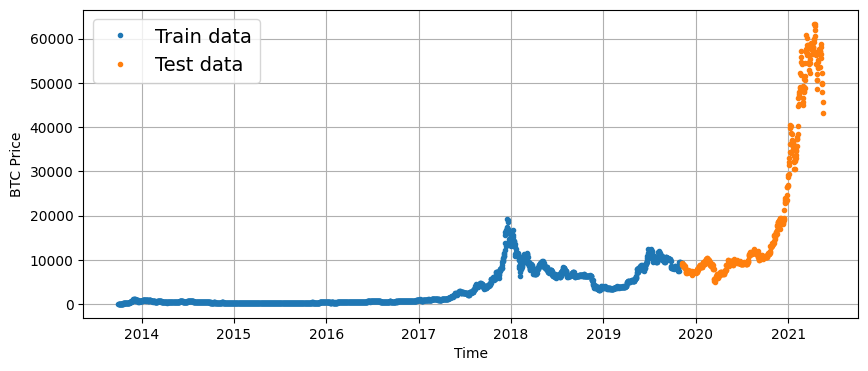

In [7]:
# Try out our plotting function
plt.figure(figsize=(10, 4))
plotTimeSeries(timesteps=X_train, values=y_train, label="Train data")
plotTimeSeries(timesteps=X_test, values=y_test, label="Test data")

### Funciónes de Métricas de Evaluación

````{admonition} mean_absolute_scaled_error
:class: dropdown
MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
```python
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  import tensorflow as tf
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season
```
````

In [8]:
def mean_absolute_scaled_error(y_true, y_pred):
  import tensorflow as tf
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) 
  return mae / mae_naive_no_season


````{admonition} evaluatePreds
:class: dropdown
Ya está modificada para tener en cuenta las predicciones multidimensionales
```python
def evaluatePreds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  import tensorflow as tf
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}
```
````

In [9]:
def evaluatePreds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  import tensorflow as tf
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

### Windowing
Windowear es un método para convertir una serie temporal en un problema de aprendizaje supervisado. Queremos hacer ventanas del pasado para predecir el futuro. Ejemplo para una serie univariante:

Ventanas de una semana (`window=7`) para predecir el siguiente valor (`horizon=1`):
```
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```
O en nuestro ejemplo de Bitcoin:
```
[123.654, 125.455, 108.584, 118.674, 121.338, 120.655, 121.795] -> [123.033]
[125.455, 108.584, 118.674, 121.338, 120.655, 121.795, 123.033] -> [124.049]
[108.584, 118.674, 121.338, 120.655, 121.795, 123.033, 124.049] -> [125.961]
```
Para eso creo una función que haga el proceso de conversión a ventanas de manera automática.

In [10]:
import tensorflow as tf
print(f"Queremos usar {prices[:7]} para predecir {prices[8]}")
print('Definimos la siguiente función para ese proposito')

Queremos usar [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] para predecir 124.049
Definimos la siguiente función para ese proposito


````{admonition} labelWindow
:class: dropdown
```python
def labelWindow(x, horizon=1):
  """
  Crea una ventana y un label a partir del input array.

  E.g. si horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]
```
````

In [11]:
def labelWindow(x, horizon=1):
  return x[:, :-horizon], x[:, -horizon:]

Testeo la función y compruebo que hace lo que debe hacer.

In [12]:
# creamos un input array: un tensor
inputArr = tf.expand_dims(tf.range(8)+1, axis = 0)
print(f"Input tensor: {inputArr}")

# Le aplicamos la función
testWindow, testLabel = labelWindow(inputArr)
print(f"Window: {tf.squeeze(testWindow).numpy()} -> Label: {tf.squeeze(testLabel).numpy()}")

Input tensor: [[1 2 3 4 5 6 7 8]]
Window: [1 2 3 4 5 6 7] -> Label: 8


Ahora necesito un método para hacer eso con toda la serie temporal.

Método:
1. Crear una ventana de una longitud especícifa
2. Usar el index de numpy para crear un array 2D de multiples ventanas, y no tener que hacer un fucking for:
```
[[0, 1, 2, 3, 4, 5, 6, 7],
[1, 2, 3, 4, 5, 6, 7, 8],
[2, 3, 4, 5, 6, 7, 8, 9]]
```
3. Usar el array 2D para indexar cada ventana a una serie objetivo (precio btc)
4. Usar la función `labelWindow()` para dar a las ventanas un horizonte.

Adaptación de este [artículo](https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5)


````{admonition} windowingTS
:class: dropdown
```python
def windowingTS(x, window_size=7, horizon=1):
  """
  Convierte un array 1D en uno 2D de ventanas secuenciales.
  """
  import numpy as np
  # 1. Crea una ventana de longitud específica (añadiéndole el horizonte para posterior labeleado)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Crea un array 2D de multiples ventanas (-1 para tener en cuenta el 0 del indexado)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Indexa la serie tempral objetivo con el 2D array 
  windowed_array = x[window_indexes]

  # 4. Obtener los labeles de cada ventana
  windows, labels = labelWindow(windowed_array, horizon=horizon)

  return windows, labels
```
````

In [13]:
def windowingTS(x, window_size=7, horizon=1):
  
  import numpy as np
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T 
  windowed_array = x[window_indexes]
  windows, labels = labelWindow(windowed_array, horizon=horizon)
  return windows, labels

In [14]:
full_windows, full_labels = windowingTS(prices, window_size=7, horizon=1)
# Los 3 primeros labeles
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


```{note}
Hay una función en Keras que hace algo parecido: `tf.keras.preprocessing.timeseries_dataset_from_array()`
```
### Model Checkpoint callback
Si el modelo lo hace mejor en la epoch 55, pero lo entreno durante 100 epochs, pierdo un modelo que se comporta mejor que el modelo final trás completar todo el entrenamiento. 

Lo que me interesa es poder disponer del mejor modelo para utilizarlo en el futuro. De esta manera lo guardo para poder cargarlo después.

````{admonition} modelCheckpoint
:class: dropdown
```python
# Función para implementar un checkpoint con un filename específico
def modelCheckpoint(model_name, save_path="experiments"):
  import os
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # crear un filepath para guardar el modelo
                                            verbose=0, # que no se raye
                                            save_best_only=True) # guardar solo el mejor modelo
```
````

In [110]:
def modelCheckpoint(model_name, save_path="experiments"):
  import os
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # crear un filepath para guardar el modelo
                                            verbose=0, # que no se raye
                                            save_best_only=True) # guardar solo el mejor modelo

### makePreds para predicciones
Creo una función para:

1. Coger el modelo entrenado
2. Meterle unos datos de entrada
3. Pasarle ese input al método `predict()`
4. Devolver las predicciones

````{admonition} makePreds
:class: dropdown
```python
def makePreds(model, input_data):
  """
  Usa el modelo para hacer predicciones sobre los datos de entrada.

  Parámetros
  ----------
  model: modelo entrenado
  input_data: datos de entrada windoweados (del mismo tipo que sobre los que ha sido entrenado el modelo)

  Devuelve las predicciones del modelo sobre los datos de entrada.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # devuelve un array 1D de predicciones
```
````

In [16]:
def makePreds(model, input_data):  
  forecast = model.predict(input_data, verbose = 0)
  return tf.squeeze(forecast) 


# Modelos
## Modelo 0: Naive Forecast (baseline)
Uno de los modelos base más comunes para la predicción de series temporales es el naive model, el cual no requiere entrenamiento. Esto es porque el siguiente valor de la serie temporal viene dado por el valor previo. La fórmula es la siguiente:

$$\hat{y}_t = y_{t-1}$$

En un sistema abierto (como el stock market) a menudo es dificil que un modelo supere al naive forecast.

Esto parece una tontería. El naive forecast sigue bien a la serie porque ES LA PUTA SERIE. Esta laggeada y ya está. Pero luego resulta que no es tan fácil hacer mejores predicciones que las que hace el naive forecast, y que no es tan facil batir sus métricas. Y sino al tiempo.

````{margin}
```{warning}
:class: dropdown
La serie de valores del Naive Forecast y de la serie original es la misma, pero hay que adecuarlas para que el valor de la predicción del día posterior sea el mismo que el día en curso. 

Para eso deslizo los Timesteps una unidad hacia delante, y para que me cuadre en longitud con el array de valores, tengo que restarle el ultimo valor a este.
```
````

In [17]:
naiveForecast = y_test[:-1]
naiveTimesteps = X_test[1:]

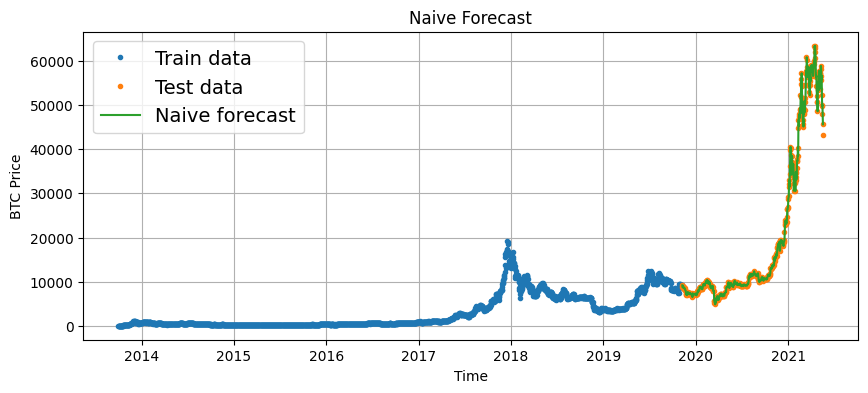

In [18]:
# Plot naive forecast
plt.figure(figsize=(10, 4))
plotTimeSeries(timesteps=X_train, values=y_train, label="Train data")
plotTimeSeries(timesteps=X_test, values=y_test ,label="Test data")
plotTimeSeries(timesteps=naiveTimesteps, values=naiveForecast,format="-", label="Naive forecast")
plt.title('Naive Forecast');

Parece que el Naive Forecast lo hace bastante bien. Vamos a hacer un zoom a ver.

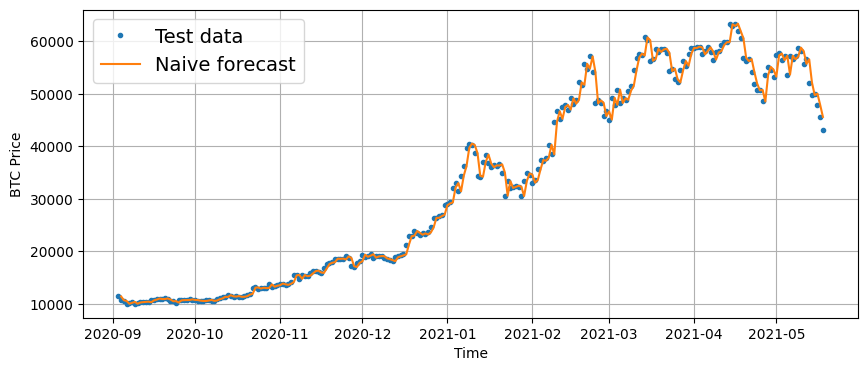

In [19]:
plt.figure(figsize=(10, 4))
offset = 300 # offset the values by 300 timesteps 
plotTimeSeries(timesteps=X_test, values=y_test, start=offset, label="Test data")
plotTimeSeries(timesteps=naiveTimesteps, values=naiveForecast, format="-", start=offset, label="Naive forecast");

Vamos a evaluarla a ver qué nos da.

In [20]:
naiveResult = evaluatePreds(y_true=y_test[1:], y_pred=naiveForecast)
print(naiveResult)

{'mae': 567.9802, 'mse': 1147547.0, 'rmse': 1071.2362, 'mape': 2.5165248, 'mase': 0.99957}


## Modelos Fully-Connected

### Modelo 1: Dense(w=7,h=1)
Primero hago la partición en conjuntos de entrenamiento y teste de la serie temporal de los precios de Bitcoin. Para eso necesito antes hacerle un windowing

In [21]:
# Windowing
WINDOW = 7
HORIZON = 1

windows, labels = windowingTS(prices, window_size=WINDOW, horizon=HORIZON)

# División de las ventanas en conjuntos de entrenamiento y testeo
train_windows, test_windows, train_labels, test_labels = train_test_split_TS(windows, labels)

Creación del modelo y compilación

```{warning}
A partir de la version de python 2.10, las primera layer de la red debe tener 
como argumento `input_shape`.
Si no tengo ni idea de cual es, lo compruebo en los datatos de entrada. 
```

In [22]:
print(f"Versión de tensorflow: {tf.__version__}")
# Dimensión de entrada
print(f'Dimensión de los datos de entrada: {train_windows[0].shape}')
input_shape = train_windows[0].shape

Versión de tensorflow: 2.10.0
Dimensión de los datos de entrada: (7,)


In [23]:
tf.random.set_seed(42)
# MODELO 1
modelo1 = tf.keras.Sequential([
  tf.keras.layers.Dense(128, input_shape = (7,), activation="relu"),
  tf.keras.layers.Dense(HORIZON, activation="linear") # la activación lineal es como no tener activación                        
], name="modelo1")

# Compilar el modelo
modelo1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # no necesitamos esto necesariamente cuando la loss function ya es MAE

Fiteado del modelo

In [24]:
modelo1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[modelCheckpoint(model_name=modelo1.name)]) #  ModelCheckpoint callback para guardar el mejor modelo

INFO:tensorflow:Assets written to: experiments\modelo1\assets
INFO:tensorflow:Assets written to: experiments\modelo1\assets
INFO:tensorflow:Assets written to: experiments\modelo1\assets
INFO:tensorflow:Assets written to: experiments\modelo1\assets
INFO:tensorflow:Assets written to: experiments\modelo1\assets
INFO:tensorflow:Assets written to: experiments\modelo1\assets
INFO:tensorflow:Assets written to: experiments\modelo1\assets
INFO:tensorflow:Assets written to: experiments\modelo1\assets
INFO:tensorflow:Assets written to: experiments\modelo1\assets
INFO:tensorflow:Assets written to: experiments\modelo1\assets
INFO:tensorflow:Assets written to: experiments\modelo1\assets
INFO:tensorflow:Assets written to: experiments\modelo1\assets
INFO:tensorflow:Assets written to: experiments\modelo1\assets
INFO:tensorflow:Assets written to: experiments\modelo1\assets
INFO:tensorflow:Assets written to: experiments\modelo1\assets
INFO:tensorflow:Assets written to: experiments\modelo1\assets
INFO:ten

#### Resultados Modelo1
Evaluación del modelo1 sobre el conjunto de testeo.

In [25]:
modelo1.evaluate(test_windows, test_labels, verbose = 0)

[683.7372436523438, 683.7372436523438]

Carga del mejor modelo trás el entrenamiento

In [26]:
# Load in saved best performing model_1 and evaluate on test data
modelo1 = tf.keras.models.load_model("experiments/modelo1")
modelo1.evaluate(test_windows, test_labels, verbose = 0)

[565.396728515625, 565.396728515625]

Predicciones del modelo1 sobre los datos de testeo y después las evalúo. Luego las comparo con las del Naive model.

In [52]:
# predicciones
modelo1_preds = makePreds(modelo1, test_windows)

# resultados
modelo1_results = evaluatePreds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=modelo1_preds)
# comparación
pd.options.display.float_format = '{:,.4f}'.format
pd.set_option("display.precision", 7)
df  =pd.DataFrame({'Naive':naiveResult,'Modelo1':modelo1_results})
df

,Naive,Modelo1
mae,567.9802,565.3967
mse,"1,147,547.0000","1,158,803.8750"
rmse,"1,071.2362","1,076.4775"
mape,2.5165,2.5267
mase,0.9996,0.9932


De momento parece que el Naive Forecast gana a este primer modelo. Lo ploteo a ver que sale.

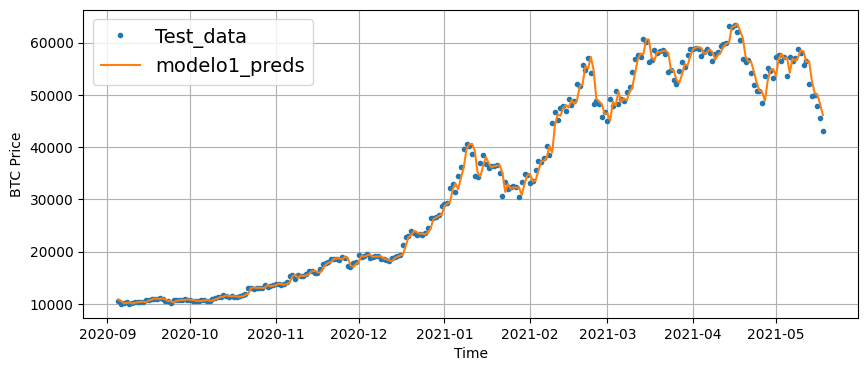

In [51]:
offset = 300
plt.figure(figsize=(10, 4))

plotTimeSeries(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plotTimeSeries(timesteps=X_test[-len(test_windows):], values=modelo1_preds, start=offset, format="-", label="modelo1_preds")

### Modelo 2: Dense(w=30, h=1)
Misma mecánica. Primero windowing y spliteado.

In [53]:
# Windowing
WINDOW = 30
HORIZON = 1

windows, labels = windowingTS(prices, window_size=WINDOW, horizon=HORIZON)

# División de las ventanas en conjuntos de entrenamiento y testeo
train_windows, test_windows, train_labels, test_labels = train_test_split_TS(windows, labels)

Creación del modelo y compilación

In [54]:
tf.random.set_seed(42)
# MODELO 2
modelo2 = tf.keras.Sequential([
  tf.keras.layers.Dense(128, input_shape = train_windows[0].shape, activation="relu"),
  tf.keras.layers.Dense(HORIZON)                     
], name="modelo2")

# Compilar el modelo
modelo2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam()) 

Fiteado del modelo

In [55]:
modelo2.fit(x=train_windows,
            y=train_labels, 
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[modelCheckpoint(model_name=modelo2.name)])

INFO:tensorflow:Assets written to: experiments\modelo2\assets
INFO:tensorflow:Assets written to: experiments\modelo2\assets
INFO:tensorflow:Assets written to: experiments\modelo2\assets
INFO:tensorflow:Assets written to: experiments\modelo2\assets
INFO:tensorflow:Assets written to: experiments\modelo2\assets
INFO:tensorflow:Assets written to: experiments\modelo2\assets
INFO:tensorflow:Assets written to: experiments\modelo2\assets
INFO:tensorflow:Assets written to: experiments\modelo2\assets
INFO:tensorflow:Assets written to: experiments\modelo2\assets
INFO:tensorflow:Assets written to: experiments\modelo2\assets
INFO:tensorflow:Assets written to: experiments\modelo2\assets
INFO:tensorflow:Assets written to: experiments\modelo2\assets
INFO:tensorflow:Assets written to: experiments\modelo2\assets
INFO:tensorflow:Assets written to: experiments\modelo2\assets
INFO:tensorflow:Assets written to: experiments\modelo2\assets
INFO:tensorflow:Assets written to: experiments\modelo2\assets
INFO:ten

#### Resultados Modelo2

Evaluación del modelo2 sobre el conjunto de testeo.

In [56]:
modelo2.evaluate(test_windows, test_labels, verbose = 0)

633.8438720703125

Carga del mejor modelo trás el entrenamiento

In [59]:
# Load in saved best performing model_1 and evaluate on test data
modelo2 = tf.keras.models.load_model("experiments/modelo2")
modelo2.evaluate(test_windows, test_labels, verbose = 0)

603.2403564453125

Predicciones del modelo2 sobre los datos de testeo y evaluación.

In [60]:
modelo2_preds = makePreds(modelo2, test_windows)

modelo2_results = evaluatePreds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=modelo2_preds)
modelo2_results

{'mae': 603.24023,
 'mse': 1244657.1,
 'rmse': 1115.642,
 'mape': 2.7345035,
 'mase': 1.0544698}

Parece que este segundo modelo se comporta aún peor que el modelo1. **¿Significa esto que un tamaño de ventana más pequeña es mejor?**


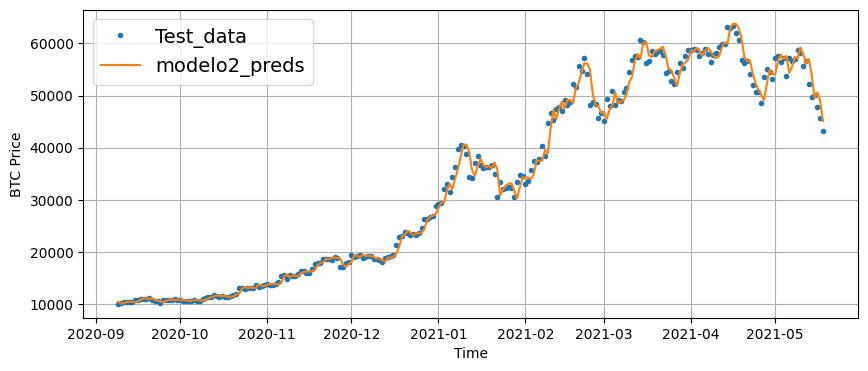

In [63]:
offset = 300
plt.figure(figsize=(10, 4))
plotTimeSeries(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plotTimeSeries(timesteps=X_test[-len(test_windows):], values=modelo2_preds, start=offset, format="-", label="modelo2_preds")

### Modelo3: Dense(w=30, h=7)

In [64]:
# Windowing
WINDOW = 30
HORIZON = 7

windows, labels = windowingTS(prices, window_size=WINDOW, horizon=HORIZON)

# División de las ventanas en conjuntos de entrenamiento y testeo
train_windows, test_windows, train_labels, test_labels = train_test_split_TS(windows, labels)

Creación del modelo y compilación

In [65]:
tf.random.set_seed(42)
# MODELO 3
modelo3 = tf.keras.Sequential([
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dense(HORIZON)                     
], name="modelo3")

# Compilar el modelo
modelo3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam()) 

Fiteado del modelo

In [66]:
modelo3.fit(x=train_windows,
            y=train_labels, 
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[modelCheckpoint(model_name=modelo3.name)]) 

INFO:tensorflow:Assets written to: experiments\modelo3\assets
INFO:tensorflow:Assets written to: experiments\modelo3\assets
INFO:tensorflow:Assets written to: experiments\modelo3\assets
INFO:tensorflow:Assets written to: experiments\modelo3\assets
INFO:tensorflow:Assets written to: experiments\modelo3\assets
INFO:tensorflow:Assets written to: experiments\modelo3\assets
INFO:tensorflow:Assets written to: experiments\modelo3\assets
INFO:tensorflow:Assets written to: experiments\modelo3\assets
INFO:tensorflow:Assets written to: experiments\modelo3\assets
INFO:tensorflow:Assets written to: experiments\modelo3\assets
INFO:tensorflow:Assets written to: experiments\modelo3\assets
INFO:tensorflow:Assets written to: experiments\modelo3\assets
INFO:tensorflow:Assets written to: experiments\modelo3\assets
INFO:tensorflow:Assets written to: experiments\modelo3\assets
INFO:tensorflow:Assets written to: experiments\modelo3\assets
INFO:tensorflow:Assets written to: experiments\modelo3\assets
INFO:ten

#### Resultados Modelo3
Evaluación del modelo3 sobre el conjunto de testeo.

In [ ]:
modelo3.evaluate(test_windows, test_labels, verbose = 0)

Carga del mejor modelo trás el entrenamiento 

In [68]:
# Load in saved best performing model_1 and evaluate on test data
modelo3 = tf.keras.models.load_model("experiments/modelo3")
modelo3.evaluate(test_windows, test_labels, verbose = 0)

1220.33642578125

Esta vez las predicciones serán vectores multidimensiones de 7 valores, puesto que he definido el horizonte = 7.

In [69]:
modelo3_preds = makePreds(modelo3, test_windows)

modelo3_results = evaluatePreds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=modelo3_preds)
modelo3_results

{'mae': 1220.3364,
 'mse': 5347482.5,
 'rmse': 1402.0818,
 'mape': 5.430424,
 'mase': 2.1715202}

Si quisiera visualizar predicciones multidimensionales, tendría que tratarlas primero, porque sino lo que voy a ver es esto:

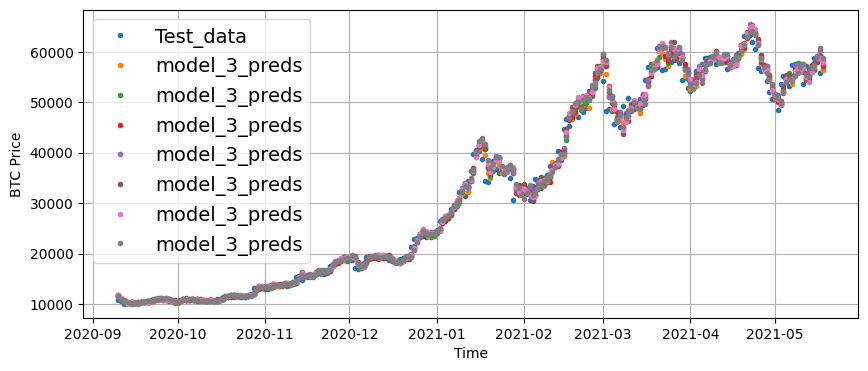

In [70]:
offset = 300
plt.figure(figsize=(10, 4))
plotTimeSeries(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
# Checking the shape of model_3_preds results in [n_test_samples, HORIZON] (this will screw up the plot)
plotTimeSeries(timesteps=X_test[-len(test_windows):], values=modelo3_preds, start=offset, label="model_3_preds")

Una castaña. Para trabajar con esto, se pueden agregar las predicciones del modelo, por ejemplo, haciendo la media. Pero hay que saber que va a haber una pérdida de información respecto de la predicción original en el proceso. Como el modelo ha sido entrenado para predecir 7 días, al reducirlas a uno gano la capacidad de plotearlo, pero pierdo la información adicional contenida en varios días.

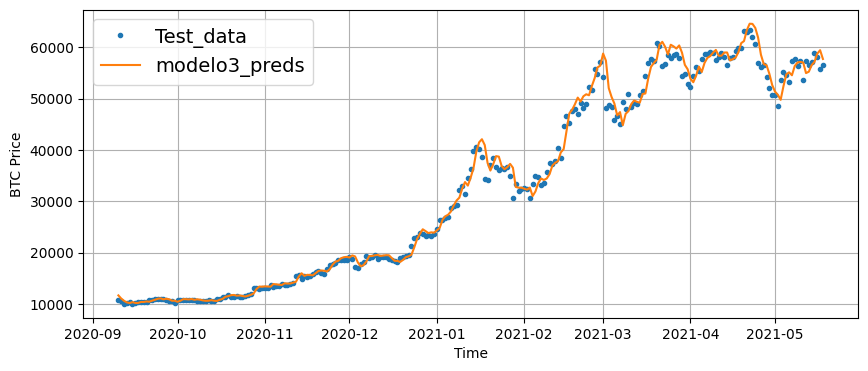

In [71]:
offset = 300
plt.figure(figsize=(10, 4))
# Plot model_3_preds by aggregating them (note: this condenses information so the preds will look fruther ahead than the test data)
plotTimeSeries(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 label="Test_data")
plotTimeSeries(timesteps=X_test[-len(test_windows):], 
                 values=tf.reduce_mean(modelo3_preds, axis=1), 
                 format="-",
                 start=offset, 
                 label="modelo3_preds")

### Qué modelo lo hace mejor
Vamos a comparar los 3 modelos contra el Naïve Model.

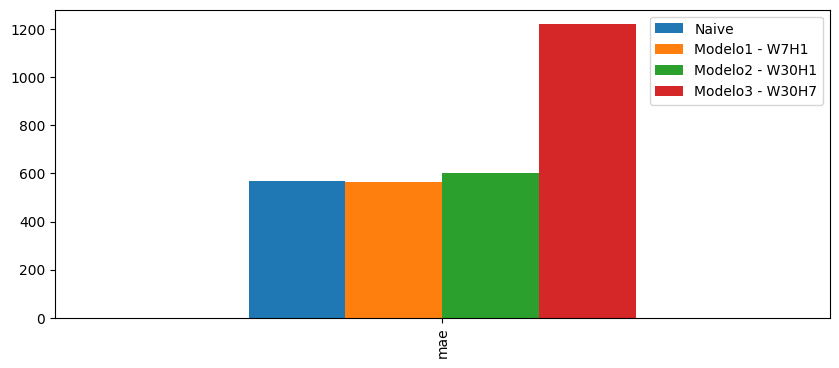

In [74]:
pd.DataFrame({"Naive": naiveResult["mae"], 
              "Modelo1 - W7H1": modelo1_results["mae"], 
              "Modelo2 - W30H1": modelo2_results["mae"], 
              "Modelo3 - W30H7": modelo3_results["mae"]}, index=["mae"]).plot(figsize=(10, 4), kind="bar");

Parece que el Naïve model es el que mejor lo hace ( es muy dificil batir ese modelo en sistemas abiertos), pero el modelo de ventana 7 y horizonte de 1 lo hace ligeramente mejor que los otros.

Asique en los próximos experimentos usaré `WINDOW=7` y `HORIZON=1` para el modelado.

```{note}
:class: dropdown
¿Por qué los resultados del Naïve model son tan buenos (o no tan malos)? Una de las razones podría deberse a la presencia de autocorrelación en los datos.

Más info sobre como la autocorrelación influye en las predicciones de un modelo: [How not to use Machine Learning for time series forecasting](https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424)
```



## Modelo 4: Conv1D
En este modelo voy a usar una capa convolucional 1D, ya que se pueden usar para problemas seq2seq (secuencia a secuencia).

Cositas para leer: [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

Como en los casos anteriores:

In [76]:
HORIZON = 1
WINDOW = 7 

full_windows, full_labels = windowingTS(prices, window_size=WINDOW, horizon=HORIZON)

train_windows, test_windows, train_labels, test_labels = train_test_split_TS(full_windows, full_labels)

Ahora, como voy a usar layers convolucionales 1D, hay que asegurarse de que las dimensiones de los arrays de entrada son correctas.

La capa Conv1D en TensorFlow toma una entrada de: (batch_size, timesteps, input_dim). En este caso serán:

* `batch_size = 32` - se recomienda 32, pero se puede cambiar
* `timesteps = WINDOW` - también se les llama features
* `input_dim = HORIZON` - valor a predecir

Tal cual está ahora mismo, la dimensión de los `timesteps` es correcta, pero hay que ajustar la de los `input_dims`.

In [78]:
train_windows[0].shape, train_labels[0].shape

((7,), (1,))

Esto se arregla pasando las ventanas por una layer `Lambda`. Al lío.

A modo de ejemplo, los datos de entrada del modelo va a ser la ventana de 7 valores que he definido antes:

In [90]:
print(f"Primera ventana: {train_windows[0]}\nDimensión de la primera ventana: {train_windows[0].shape}")

Primera ventana: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ]
Dimensión de la primera ventana: (7,)


Convierto en tensor la primera ventana. Al final aquí no le estoy cambiando la dimensión ni nada, sigue siendo el mismo array con los mismos valores, pero de distinto tipo.

In [103]:
train_windows[0], type(train_windows[0]), train_windows[0].shape

(array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  ]),
 numpy.ndarray,
 (7,))

In [104]:
# conversión en tensor de la primera ventana
x = tf.constant(train_windows[0])

x, type(x), x.shape

(<tf.Tensor: shape=(7,), dtype=float64, numpy=
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  ])>,
 tensorflow.python.framework.ops.EagerTensor,
 TensorShape([7]))

Ahora paso el tensor por la layer `Lambda`, y cambio su dimensión.

In [106]:
expand_dims_layer = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1))
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim) 
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


Pues ya estaría. Ahora se contruye el modelo como siempre, incorporando esa `Lambda`layer. Esta capa va a transformar cada ventana que le pasemos como input al modelo.

In [108]:
tf.random.set_seed(42)
# MODELO 4
modelo4 = tf.keras.Sequential([
  # Lambda layer para reshapear inputs
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size / Conv1D 3D input requirements

  tf.keras.layers.Conv1D(filters = 128, kernel_size = 5,  padding="causal", activation="relu"),
  tf.keras.layers.Dense(HORIZON)                     
], name="modelo4")

# Compilar el modelo
modelo4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam()) 

In [111]:
modelo4.fit(train_windows,
            train_labels,
            batch_size=128, 
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[modelCheckpoint(model_name=modelo4.name)])

INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


INFO:tensorflow:Assets written to: experiments\modelo4\assets


#### Resultados Modelo4
¿Qué pinta tiene un Lambda layer en el summary?

In [112]:
modelo4.summary()

Model: "modelo4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


Carga del mejor modelo trás el entrenamiento

In [113]:
modelo4 = tf.keras.models.load_model("experiments/modelo4")
modelo4.evaluate(test_windows, test_labels, verbose = 0)

569.4754028320312

In [114]:
modelo4_preds = makePreds(modelo4, test_windows)

modelo4_results = evaluatePreds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=modelo4_preds)
modelo4_results

{'mae': 569.4754,
 'mse': 1180036.1,
 'rmse': 1086.2947,
 'mape': 2.5538876,
 'mase': 1.0004106}

## Modelo 5: RNN (LTSM)

Para este modelo también hay que tener cuidado con las dimensiones de los datos de entrada. Esta va mediante la API Functional y reusando los datos del modelo anterior.

In [121]:
tf.random.set_seed(42)

# MODELO 5
inputs = tf.keras.layers.Input(shape=(WINDOW,))

# Lambda layer para reshapear inputs, igual que antes
x = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) 

# x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
x = tf.keras.layers.LSTM(128, activation="relu")(x) # using the tanh loss function results in a massive error

# Add another optional dense layer (you could add more of these to see if they improve model performance)
x = tf.keras.layers.Dense(32, activation="relu")(x)
output = tf.keras.layers.Dense(HORIZON)(x)

modelo5 = tf.keras.Model(inputs=inputs, outputs=output, name="modelo5")

# Compilar el modelo
modelo5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

In [123]:
# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554 
modelo5.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose = 0,
            validation_data=(test_windows, test_labels),
            callbacks=[modelCheckpoint(model_name=modelo5.name)])

INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


INFO:tensorflow:Assets written to: experiments\modelo5\assets


### Resultados Modelo5

In [125]:
# Load in best version of model 5 and evaluate on the test data
modelo5 = tf.keras.models.load_model("experiments/modelo5/")
modelo5.evaluate(test_windows, test_labels, verbose = 0)

568.0767822265625

In [126]:
# predicciones
modelo5_preds = makePreds(modelo5, test_windows)

# resultados
modelo5_results = evaluatePreds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=modelo1_preds)

modelo5_results

{'mae': 565.39667,
 'mse': 1158803.9,
 'rmse': 1076.4775,
 'mape': 2.5267334,
 'mase': 0.99324536}

Parece que incluso una LSTM no gana al Naïve model.

A ver si usando un modelo multivariante...